In [1]:
# MODULES
from mne.io import read_raw_brainvision
from TFG_utils import (returnFolders, returnFiles, take_vmrk_files, take_vhdr_files, take_eeg_files, plot_eeg_time, plot_PSD, plot_freq_response)
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
import mne
import numpy as np
from scipy import signal
%matplotlib notebook

In [2]:
# COLLECTING DATA
foldername = 'EEG_folders'
EEG_folders=returnFolders(foldername)
EEG_files=returnFiles(EEG_folders)
vmrk_files=take_vmrk_files(EEG_files)
vhdr_files=take_vhdr_files(EEG_files)
eeg_files=take_eeg_files(EEG_files)

# FILTERING

NOTCH_FILTER: https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.notch_filter

CONSTRUCT IIR FILTER: https://mne.tools/stable/generated/mne.filter.construct_iir_filter.html#mne.filter.construct_iir_filter

FILTER: https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.filter

PSD: https://mne.tools/dev/generated/mne.io.Raw.html#mne.io.Raw.plot_psd


Extracting parameters from EEG_folders\eeg_example_1\Neuromarketing3850.vhdr...
Setting channel info structure...
Reading 0 ... 240139  =      0.000 ...   480.278 secs...

 NOTCH FILTER

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 4 (effective, after forward-backward)
- Cutoffs at 49.00, 51.00 Hz: -6.02, -6.02 dB



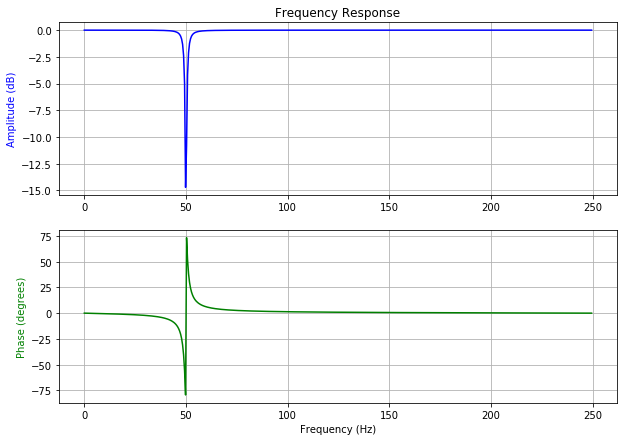

Setting up band-stop filter from 49 - 51 Hz

No projector specified for this dataset. Please consider the method self.add_proj.
Effective window size : 4.096 (s)
No projector specified for this dataset. Please consider the method self.add_proj.
Effective window size : 4.096 (s)


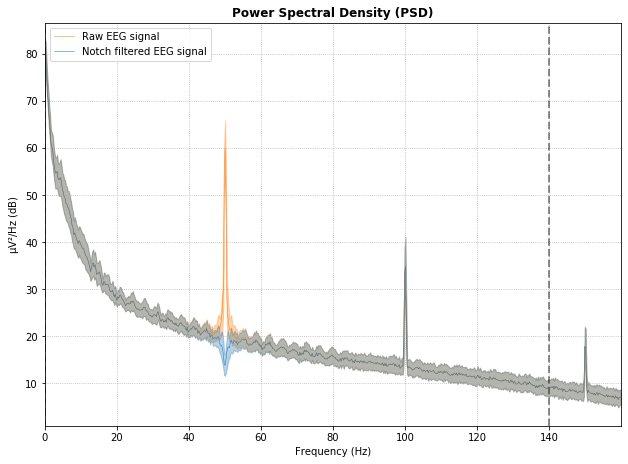


 BAND PASS FILTER (FIR)
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hann window with 0.0546 passband ripple and 44 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 10001 samples (20.002 sec)



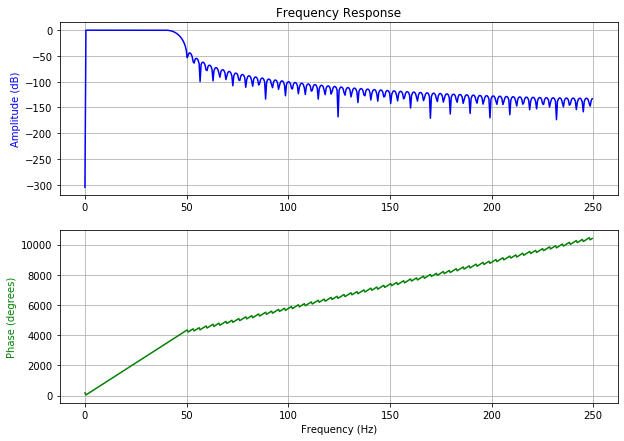

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hann window with 0.0546 passband ripple and 44 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 10001 samples (20.002 sec)

No projector specified for this dataset. Please consider the method self.add_proj.
Effective window size : 4.096 (s)
No projector specified for this dataset. Please consider the method self.add_proj.
Effective window size : 4.096 (s)


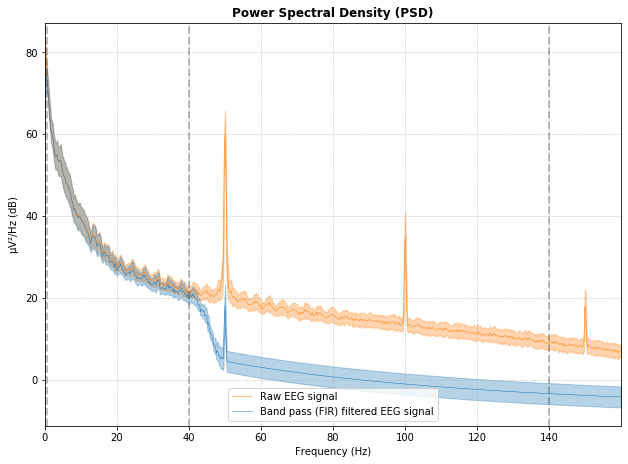


 BAND PASS FILTER (IIR)

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 20 (effective, after forward-backward)
- Cutoffs at 0.50, 40.00 Hz: -5.64, -6.02 dB



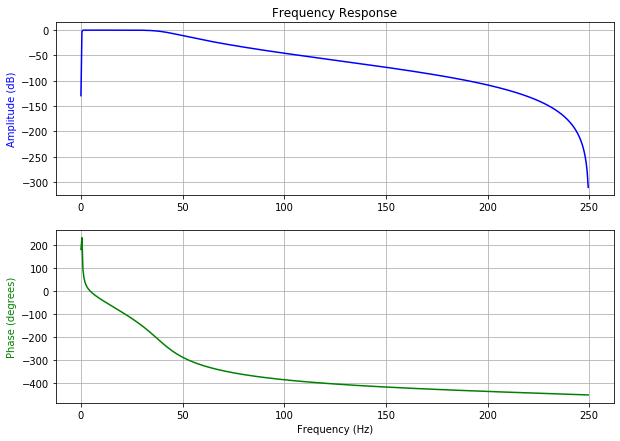

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

No projector specified for this dataset. Please consider the method self.add_proj.
Effective window size : 4.096 (s)
No projector specified for this dataset. Please consider the method self.add_proj.
Effective window size : 4.096 (s)


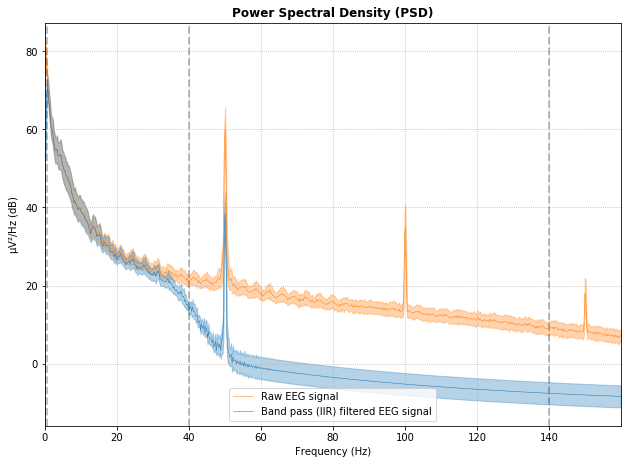

In [19]:
verbose=True

#for i in range(len(EEG_folders)):
for i in range(1):
    raw = read_raw_brainvision(vhdr_files[i],verbose=verbose).load_data(verbose=verbose)

    # FILTERING
    raw_filtered=raw.copy().set_montage("standard_1020",verbose=verbose) # No estoy segura de que sea este montaje¿?
    sampling_freq = int(raw.info['sfreq'])
    
    #Notch filter (IIR)
    notch_filtered=raw.copy().set_montage("standard_1020",verbose=verbose)
    print('\n','\033[1;34m' + 'NOTCH FILTER'+'\033[0;m')
    f0=50
    iir_params = dict(order=1, ftype='butter', output='ba')
    iir_params = mne.filter.construct_iir_filter(iir_params,sfreq=sampling_freq, f_pass= [49, 51],btype='bandstop',return_copy=False, verbose=verbose)
    b,a=(iir_params['b'],iir_params['a'])
    plot_freq_response(b,a,sampling_freq)
    notch_filtered.notch_filter(f0,method='iir',iir_params={'b':b,'a':a},verbose=verbose)
    plot_PSD(raw,notch_filtered, filter_applied='Notch filtered EEG signal')
    plt.show()
    
    #Band pass filter (FIR)
    print('\n','\033[1;34m' + 'BAND PASS FILTER (FIR)'+'\033[0;m')
    bpfir_filtered=raw.copy().set_montage("standard_1020",verbose=verbose)
    f1,f2=(0.5,40)
    numtaps='20'+'s' #filter lenght in sec
    b = mne.filter.create_filter(bpfir_filtered['all'][1], filter_length=numtaps,sfreq=sampling_freq, l_freq=f1, h_freq=f2,
                                 method='fir', fir_window='hann',fir_design='firwin', verbose=verbose)
    plot_freq_response(b,1,sampling_freq)
    bpfir_filtered.filter(l_freq=f1, h_freq=f2, filter_length=numtaps, method='fir', fir_window='hann', fir_design='firwin',verbose=verbose)
    plot_PSD(raw,bpfir_filtered, filter_applied='Band pass (FIR) filtered EEG signal')
    plt.show()

    #Band pass filter (IIR)
    print('\n','\033[1;34m' + 'BAND PASS FILTER (IIR)'+'\033[0;m')
    bpiir_filtered=raw.copy().set_montage("standard_1020",verbose=verbose)
    iir_params = dict(order=5, ftype='butter', output='ba')
    iir_params = mne.filter.construct_iir_filter(iir_params, f_pass=(f1,f2),sfreq=sampling_freq, btype='bandpass',return_copy=False, verbose=verbose)
    b,a=(iir_params['b'],iir_params['a'])
    plot_freq_response(b,a,sampling_freq)
    bpiir_filtered.filter(l_freq=f1, h_freq=f2,method='iir',iir_params=iir_params, verbose=verbose)
    plot_PSD(raw,bpiir_filtered, filter_applied='Band pass (IIR) filtered EEG signal')
    plt.show()
    
    #raws.append(raw)
    #raws_filtered.append(raw_filtered)

# EPOCHS por anuncios

https://mne.tools/stable/generated/mne.Epochs.html?highlight=epochs#mne.Epochs

In [ ]:
spots_times_sec = [0, 60, 120, 180, 226, 287, 347] # Time (sec) at which each spot begins

In [ ]:
mne.Epochs(raw, events, event_id=None, tmin=- 0.2, tmax=0.5, baseline=None, 0, picks=None, preload=False, 
           reject=None, flat=None, proj=True, decim=1, reject_tmin=None, reject_tmax=None, detrend=None, 
           on_missing='error', reject_by_annotation=True, metadata=None, event_repeated='error', verbose=None)

# ICA

In [ ]:
# ICA
#for raw_filtered in raws_filtered:
    #ica = ICA(n_components=None, method='infomax', fit_params=dict(extended=True), random_state=1)
    #ica.fit(raw_filtered)   
    #ica.plot_sources(raw_filtered,title='Raw EEG signal')
    #ica.plot_components(inst=raw_filtered)